# Getting started with Kinesis

In this notebook, we will generate a mock cluster, observe (add noise) and fit to see if we recover the true parameters of its internal kinematics.

Notes on dependences
- [gapipes](https://github.com/smoh/gapipes): for custom pandas accessor `g` to get covariance matrices, astropy coordinate objects..
- [arviz](https://github.com/arviz-devs/arviz): for visualization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
import astropy.units as u
import astropy.coordinates as coords
import arviz as az

# project dependencies
import gapipes as gp
import kinesis as kn

In [2]:
np.random.seed(18324)

## Making and observing a mock cluster

First, let's make a cluster with some fiducial parameters.

In [4]:
N = 150  # number of sources
b0 = np.array([17.7, 41.2, 13.3])    # pc
v0 = np.array([-6.32, 45.24, 5.30])  # [vx, vy, vz] in km/s
sigv = 1.  # dispersion, km/s

cl = kn.Cluster(v0, sigv, b0=b0)

The cluster currently has no members. We need to 'sample' the cluster in order to populate it. There are two methods for sampling a cluster:
- sample_sphere: sampling uniformly within a maximum radius
- sample_at: sample at exactly the positions you want by giving it astropy coordinates.

Let's do uniform sphere for now. All normal methods of `Cluster` will return itself with modified attributes for method chaining.
Sampling will modify its `members` from `None` to an instance of `ClusterMembers`.

In [6]:
cl.sample_sphere(N=N, Rmax=5)
cl.members

There are two Gaia-like DataFrame associated with `ClusterMembers`:
- `truths`: this is the noise-free Gaia data consistent with the `Cluster`'s internal motions
- `observed`: this is the noise-added Gaia data. If the `ClusterMembers` has not been `observe`d, it will be `None`.

Now let's `observe` the cluster. In order to observe, you need to specify the 3x3 covariance matrix for (parallax, pmra, pmdec) with `cov` keyword. If `cov` is (3,3) array, this will be assumed for all stars. You can also specify different covariance matrix for different stars by specifying `cov` to be (N, 3, 3) array. The noise model is assumed to be Gaussian.

It is also possible to specify covariance by giving another Gaia-like data frame using `error_from` keyword. The following columns needed to construct to covariance matrix are expected: `parallax_error`, `pmra_error`, `pmdec_error`, `parallax_pmra_corr`, `parallax_pmdec_corr`, `pmra_pmdec_corr`. This is useful, for example, if you want to simulate data as noisy as the actual Gaia data you want to model.

Radial velocity errors should be specified separately with `rv_error` keyword, which should be 1-d array with `N` elements, each specifying the Gaussian standard deviation in km/s. If any element in `rv_error` is `np.nan`, it is assumed that the star does not have RV measurement.

This will add noise to the astrometry and radial velocities of the cluster members, and the noise-added Gaia-like data frame is now accessible with `cl.members.observed`.


Let's specify simply 0.01 mas or mas/yr errors for parallax and pmra/pmdec and no available RVs.

In [8]:
cl.observe(cov=np.eye(3)*0.01)

Cluster(b0=[17.7 41.2 13.3], v0=[-6.32 45.24  5.3 ], sigmav=1.0)

In [9]:
cl.members.observed.head()

ra        dec   parallax        pmra      pmdec  parallax_pmra_corr  \
0  69.827908  15.519434  21.658627  100.052890 -26.044631                 0.0   
1  63.449065  18.338080  20.766187  116.685278 -26.140222                 0.0   
2  67.364160  20.868653  21.499381   97.637078 -44.203983                 0.0   
3  62.220135  16.061914  20.091140  116.236887 -26.155718                 0.0   
4  61.149763  17.653502  22.460105  124.989805 -28.335939                 0.0   

   parallax_pmdec_corr  pmra_pmdec_corr  parallax_error  pmra_error  \
0                  0.0              0.0             0.1         0.1   
1                  0.0              0.0             0.1         0.1   
2                  0.0              0.0             0.1         0.1   
3                  0.0              0.0             0.1         0.1   
4                  0.0              0.0             0.1         0.1   

   pmdec_error  
0          0.1  
1          0.1  
2          0.1  
3          0.1  
4          0.1

## Fitting the mock data

Now let's try to fit the mock data that we generated.
Under the hood, kinesis uses [stan](https://mc-stan.org/) using its python interface [pystan](https://pystan.readthedocs.io/en/latest/).

In [8]:
fitter = kn.Fitter(include_T=False, recompile=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_47c60c044460f8a93fb3bb3ea5a6ba35 NOW.
INFO:kinesis.models:Compiling general_model


In [9]:
df = cl.members.observed.copy()
fit = fitter.fit(df, sample=False)
print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
print(f"diff from truth: {fit['v0']-v0}, {fit['sigv']-sigv:.4f}")

v0, sigv = [-6.0485426  45.77930913  5.55432163], 0.9072
diff from truth: [0.2714574  0.53930913 0.25432163], -0.0928


In [10]:
stanfit = fitter.fit(df)

In [14]:
stanfit.azfit

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [15]:
azfit=stanfit.azfit

In [19]:
az.summary(azfit, var_names=['v0','sigv'])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
v0[0]  -6.060  0.434  -6.856   -5.228      0.011    0.008    1615.0  1607.0   
v0[1]  45.754  1.000  43.927   47.715      0.025    0.018    1632.0  1632.0   
v0[2]   5.546  0.328   4.920    6.143      0.008    0.006    1649.0  1649.0   
sigv    0.919  0.037   0.850    0.990      0.001    0.000    5188.0  5174.0   

       ess_bulk  ess_tail  r_hat  
v0[0]    1625.0    2122.0    1.0  
v0[1]    1640.0    2098.0    1.0  
v0[2]    1653.0    1991.0    1.0  
sigv     5183.0    3203.0    1.0

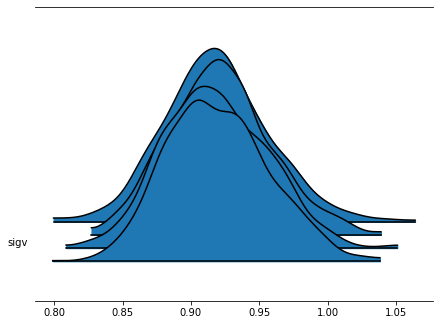

In [16]:
az.plot_forest(azfit, kind='ridgeplot', var_names=['sigv']);

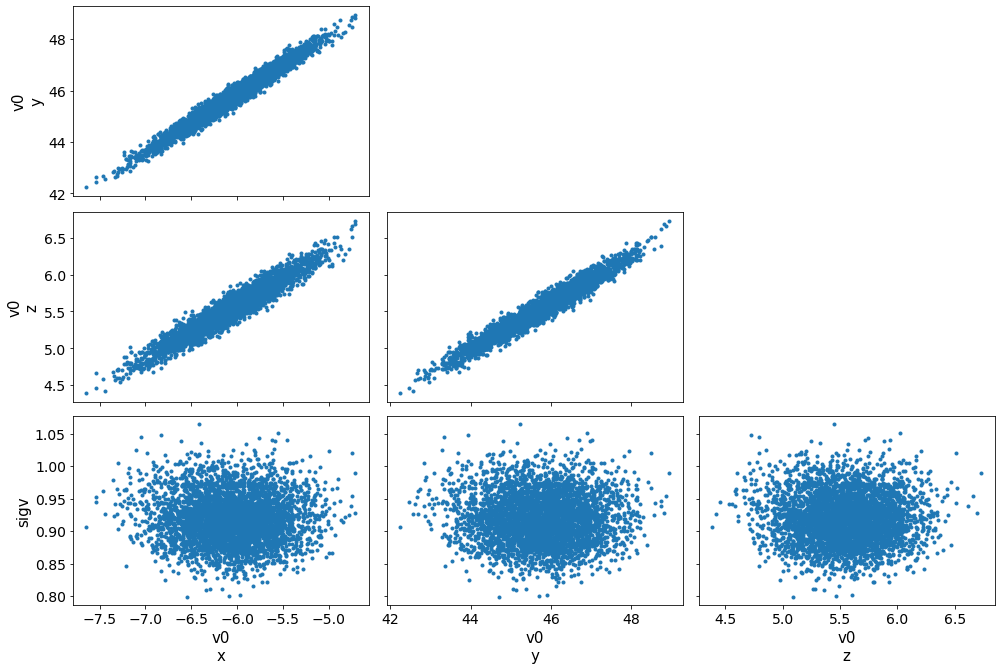

In [21]:
az.plot_pair(azfit, var_names=['v0','sigv']);

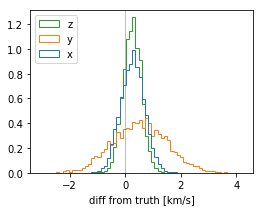

In [12]:
v0_diff = stanfit['v0'] - cl.v0[None,:]

plt.figure(figsize=(4,3))
plt.hist(v0_diff, bins=64, histtype='step', density=True, label=['x','y','z']);
plt.xlabel("diff from truth [km/s]");
plt.legend(loc='upper left');
plt.axvline(0, c='gray', lw=.5);

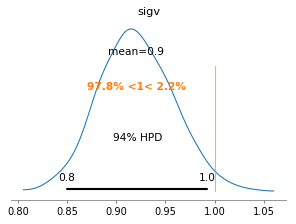

In [13]:
az.plot_posterior(azfit, var_names=['sigv'], ref_val=cl.sigmav, figsize=(4,3));

In [14]:
# plt.figure(figsize=(4,3))
# g = np.einsum('ni,nij,nj->n', a-r['a_model'], np.linalg.inv(C), a-r['a_model'])

# plt.hist(g, 32, density=True);
# plt.hist(g, np.logspace(0, 4, 32), density=True);
# plt.xscale('log');
# plt.yscale('log')

### Basic cluster model with partial RVs

In [15]:
N = 150
b0 = np.array([17.7, 41.2, 13.3])    # pc
v0 = np.array([-6.32, 45.24, 5.30])
sigv = 1.

cl = kn.Cluster(v0, sigv, b0=b0)\
       .sample_sphere(N=N, Rmax=5)\
       .observe(cov=np.eye(3)*0.01)

# Give random half of the stars RV with 0.5 km/s uncertainty
Nrv = int(N*0.5)
rv_error = 0.5
irand = np.random.choice(np.arange(N), size=Nrv, replace=False)

df = cl.members.observed.copy()
df['radial_velocity'] = np.random.normal(cl.members.truth['radial_velocity'].values, rv_error)
df['radial_velocity_error'] = rv_error

In [16]:
df = cl.members.observed.copy()
fit = fitter.fit(df, sample=False)
print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
print(f"diff from truth: {fit['v0']-v0}, {fit['sigv']-sigv:.4f}")

v0, sigv = [-5.92897309 46.06913061  5.49316135], 0.9835
diff from truth: [0.39102691 0.82913061 0.19316135], -0.0165


In [17]:
stanfit_partialrv = fitter.fit(df)

In [18]:
# workaround for a bug in arviz instantiating InferenceData
d = stanfit_partialrv.extract(permuted=False, pars=['v0', 'sigv'])
d = {k:np.swapaxes(v, 0, 1) for k,v in d.items()}
azfit_partialrv = az.from_dict(d)

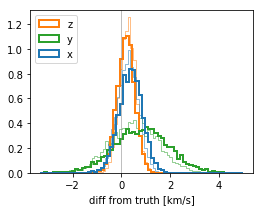

In [19]:
v0_diff0 = stanfit['v0'] - cl.v0[None,:]
v0_diff = stanfit_partialrv['v0'] - cl.v0[None,:]

plt.figure(figsize=(4,3))
color = ['tab:blue', 'tab:green', 'tab:orange']
plt.hist(v0_diff0, bins=64, histtype='step', density=True, color=color, lw=.5);
plt.hist(v0_diff, bins=64, histtype='step', density=True, color=color, label=['x','y','z'], lw=2);
plt.xlabel("diff from truth [km/s]");
plt.legend(loc='upper left');
plt.axvline(0, c='gray', lw=.5);

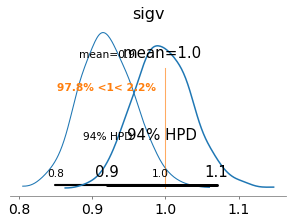

In [20]:
axs = az.plot_posterior(azfit, var_names=['sigv'], ref_val=cl.sigmav, figsize=(4,3))
az.plot_posterior(azfit_partialrv, var_names=['sigv'], ax=axs);

## Cluster with rotation

In [21]:
N = 150
b0 = np.array([17.7, 41.2, 13.3])    # pc
v0 = np.array([-6.32, 45.24, 5.30])
sigv = 1.
omegas = [40., 20., 50.]

cl = kn.Cluster(v0, sigv, b0=b0, omegas=omegas)\
       .sample_sphere(N=N, Rmax=15)\
       .observe(cov=np.eye(3)*0.001)
cl0 = kn.Cluster(v0, sigv, b0=b0).sample_at(cl.members.truth.g.icrs)

# Give random half of the stars RV with 0.5 km/s uncertainty
Nrv = int(N*0.5)
rv_error = 0.5
irand = np.random.choice(np.arange(N), size=Nrv, replace=False)

df = cl.members.observed.copy()
df['radial_velocity'] = np.random.normal(cl.members.truth['radial_velocity'].values, rv_error)
df['radial_velocity_error'] = rv_error

In [22]:
m = kn.Fitter(include_T=True)
fit = m.fit(df, sample=False, b0=b0)

INFO:kinesis.models:Reading model from disk


In [23]:
print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
print(f"diff from truth: {fit['v0']-v0}, {fit['sigv']-sigv:.4f}")
print(f"{fit['T_param']}")
print(f"{cl.T}")

v0, sigv = [-6.382561   45.25883593  5.52632739], 0.9632
diff from truth: [-0.062561    0.01883593  0.22632739], -0.0368
[[ -5.47942742 -48.81690422  14.15808424]
 [ 27.02856238   6.34378433 -29.12948134]
 [ -4.03730063  37.49138498  -3.81971577]]
[[  0. -50.  20.]
 [ 50.   0. -40.]
 [-20.  40.   0.]]


In [ ]:
# omegax = 0.5*(r['T_param'][2, 1] - r['T_param'][1, 2])
# omegay = 0.5*(r['T_param'][0, 2] - r['T_param'][2, 0])
# omegaz = 0.5*(r['T_param'][1, 0] - r['T_param'][0, 1])

# w1 = 0.5*(r['T_param'][2, 1] + r['T_param'][1, 2])
# w2 = 0.5*(r['T_param'][0, 2] + r['T_param'][2, 0])
# w3 = 0.5*(r['T_param'][1, 0] + r['T_param'][0, 1])
# w4 = r['T_param'][0, 0]
# w5 = r['T_param'][1, 1]
# kappa = w4 + w5 + r['T_param'][2, 2]
# print(omegax, omegay, omegaz)
# print(w1, w2, w3)
# print(w4, w5)
# print(kappa)

In [25]:
stanfit = m.fit(df, b0=b0)

In [26]:
azfit = az.from_pystan(stanfit)

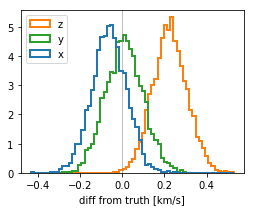

In [27]:
v0_diff = stanfit['v0'] - cl.v0[None,:]

plt.figure(figsize=(4,3))
color = ['tab:blue', 'tab:green', 'tab:orange']
plt.hist(v0_diff, bins=64, histtype='step', density=True, color=color, label=['x','y','z'], lw=2);
plt.xlabel("diff from truth [km/s]");
plt.legend(loc='upper left');
plt.axvline(0, c='gray', lw=.5);

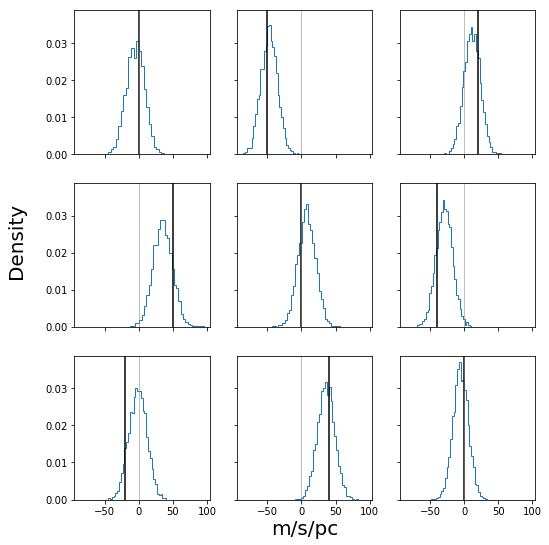

In [28]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.1, top=0.95, right=0.95, left=0.15)
ax = ax.ravel()
for cax, cT, truth in zip(ax, stanfit["T_param"].reshape((-1, 9)).T, cl.T.ravel()):
    cax.hist(cT, bins=32, density=True, histtype="step")
    cax.axvline(truth, c="k")
    cax.axvline(0, c="gray", lw=0.5)
fig.text(0.55, 0.05, "m/s/pc", ha="center", va="center", size=20)
fig.text(0.05, 0.55, "Density", ha="center", va="center", rotation=90, size=20)
fig.savefig("mock_posterior_T.png")

## Cluster with rotation - ideal case

Test the most ideal case when the cluster has small dispersion and all velocities are measured to high precision.

In [29]:
N = 150
b0 = np.array([17.7, 41.2, 13.3])    # pc
v0 = np.array([-6.32, 45.24, 5.30])
sigv = 0.1 # small dispersion
omegas = [40., 20., 50.]

cl = kn.Cluster(v0, sigv, b0=b0, omegas=omegas)\
       .sample_sphere(N=N, Rmax=15)\
       .observe(cov=np.eye(3)*0.001)
cl0 = kn.Cluster(v0, sigv, b0=b0).sample_at(cl.members.truth.g.icrs)

# Give all stars observed RV with small uncertainty
Nrv = int(N)
rv_error = 0.1
irand = np.random.choice(np.arange(N), size=Nrv, replace=False)

df = cl.members.observed.copy()
df['radial_velocity'] = np.random.normal(cl.members.truth['radial_velocity'].values, rv_error)
df['radial_velocity_error'] = rv_error

In [30]:
m = kn.Fitter(include_T=True)
fit = m.fit(df, sample=False, b0=b0)

INFO:kinesis.models:Reading model from disk


In [31]:
print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
print(f"diff from truth: {fit['v0']-v0}, {fit['sigv']-sigv:.4f}")
print(f"{fit['T_param']}")
print(f"{cl.T}")

v0, sigv = [-6.31158325 45.23302118  5.30911615], 0.0974
diff from truth: [ 0.00841675 -0.00697882  0.00911615], -0.0026
[[ -0.53514835 -49.6406874   18.48196561]
 [ 52.87740998   3.07364283 -38.98217046]
 [-19.87667794  42.07821215   2.22755235]]
[[  0. -50.  20.]
 [ 50.   0. -40.]
 [-20.  40.   0.]]


In [32]:
stanfit = m.fit(df, b0=b0)

In [33]:
azfit = az.from_pystan(stanfit, coords={'x':['v1','v2','v3']}, dims={'v0':['x']})
azfit.posterior

<xarray.Dataset>
Dimensions:         (T_param_dim_0: 3, T_param_dim_1: 3, a_model_dim_0: 150, a_model_dim_1: 3, chain: 4, draw: 1000, rv_model_dim_0: 150, x: 3)
Coordinates:
  * chain           (chain) int64 0 1 2 3
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * x               (x) <U2 'v1' 'v2' 'v3'
  * a_model_dim_0   (a_model_dim_0) int64 0 1 2 3 4 5 ... 145 146 147 148 149
  * a_model_dim_1   (a_model_dim_1) int64 0 1 2
  * rv_model_dim_0  (rv_model_dim_0) int64 0 1 2 3 4 5 ... 145 146 147 148 149
  * T_param_dim_0   (T_param_dim_0) int64 0 1 2
  * T_param_dim_1   (T_param_dim_1) int64 0 1 2
Data variables:
    v0              (chain, draw, x) float64 -6.303 45.23 5.299 ... 45.23 5.306
    sigv            (chain, draw) float64 0.1037 0.0987 0.104 ... 0.1028 0.1002
    a_model         (chain, draw, a_model_dim_0, a_model_dim_1) float64 23.24 ... 18.95
    rv_model        (chain, draw, rv_model_dim_0) float64 42.07 41.79 ... 35.94
    T_param    

In [34]:
azfit.sample_stats

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    accept_stat  (chain, draw) float64 0.8102 0.9105 0.9356 ... 0.9653 0.813
    stepsize     (chain, draw) float64 0.1635 0.1635 0.1635 ... 0.171 0.171
    treedepth    (chain, draw) int64 5 6 5 5 5 5 5 5 5 5 ... 6 7 6 10 6 5 6 5 6
    n_leapfrog   (chain, draw) int64 31 63 31 63 31 31 ... 1023 127 63 127 31 63
    diverging    (chain, draw) bool False False False ... False False False
    energy       (chain, draw) float64 -1.252e+03 -1.248e+03 ... -1.273e+03
    lp           (chain, draw) float64 1.326e+03 1.335e+03 ... 1.345e+03
Attributes:
    created_at:                 2019-05-22T21:57:36.944296
    inference_library:          pystan
    inference_library_version:  2.18.0.0

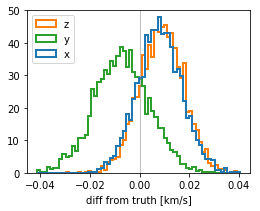

In [35]:
v0_diff = stanfit['v0'] - cl.v0[None,:]

plt.figure(figsize=(4,3))
color = ['tab:blue', 'tab:green', 'tab:orange']
plt.hist(v0_diff, bins=64, histtype='step', density=True, color=color, label=['x','y','z'], lw=2);
plt.xlabel("diff from truth [km/s]");
plt.legend(loc='upper left');
plt.axvline(0, c='gray', lw=.5);

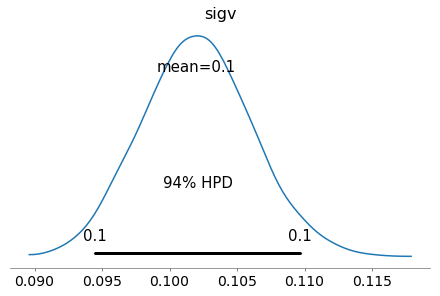

In [36]:
az.plot_posterior(azfit, var_names=['sigv']);

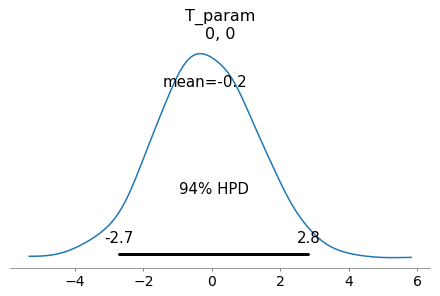

In [37]:
az.plot_posterior(azfit, var_names=['T_param'], coords={'T_param_dim_0':[0], 'T_param_dim_1':[0]});

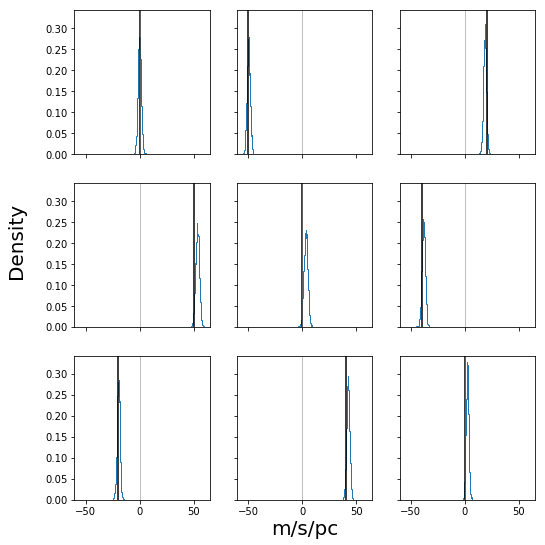

In [38]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.1, top=0.95, right=0.95, left=0.15)
ax = ax.ravel()
for cax, cT, truth in zip(ax, stanfit["T_param"].reshape((-1, 9)).T, cl.T.ravel()):
    cax.hist(cT, bins=32, density=True, histtype="step")
    cax.axvline(truth, c="k")
    cax.axvline(0, c="gray", lw=0.5)
fig.text(0.55, 0.05, "m/s/pc", ha="center", va="center", size=20)
fig.text(0.05, 0.55, "Density", ha="center", va="center", rotation=90, size=20)
fig.savefig("mock_posterior_T.png")

In [40]:
az.summary(azfit, var_names=['v0', 'sigv', 'T_param'])

mean     sd  mcse_mean  mcse_sd  hpd_3%  hpd_97%  ess_mean  \
v0[0]         -6.312  0.009      0.000    0.000  -6.329   -6.295    4194.0   
v0[1]         45.233  0.011      0.000    0.000  45.213   45.255    3715.0   
v0[2]          5.309  0.009      0.000    0.000   5.292    5.325    3736.0   
sigv           0.102  0.004      0.000    0.000   0.094    0.110    4079.0   
T_param[0,0]  -0.193  1.470      0.023    0.026  -2.713    2.825    4264.0   
T_param[0,1] -49.671  1.497      0.024    0.017 -52.673  -47.076    4041.0   
T_param[0,2]  18.266  1.330      0.021    0.015  15.793   20.782    4000.0   
T_param[1,0]  53.288  1.709      0.027    0.019  49.914   56.317    4033.0   
T_param[1,1]   3.204  1.761      0.028    0.021   0.158    6.763    3929.0   
T_param[1,2] -38.332  1.551      0.024    0.017 -41.152  -35.436    4335.0   
T_param[2,0] -19.730  1.366      0.021    0.015 -22.275  -17.212    4171.0   
T_param[2,1]  42.125  1.415      0.022    0.016  39.570   44.876    4161.0   
T_param[2,2]   2.086  1.235      0.019    0.015  -0.092    4.417    4306.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
v0[0]         4193.0    4182.0    3104.0    1.0  
v0[1]         3715.0    3726.0    2801.0    1.0  
v0[2]         3736.0    3744.0    2761.0    1.0  
sigv          4065.0    4091.0    2782.0    1.0  
T_param[0,0]  1603.0    4248.0    2994.0    1.0  
T_param[0,1]  4041.0    4047.0    2859.0    1.0  
T_param[0,2]  4000.0    4002.0    2856.0    1.0  
T_param[1,0]  4033.0    4037.0    2718.0    1.0  
T_param[1,1]  3461.0    3938.0    2981.0    1.0  
T_param[1,2]  4335.0    4326.0    3082.0    1.0  
T_param[2,0]  4171.0    4169.0    2701.0    1.0  
T_param[2,1]  4161.0    4166.0    3082.0    1.0  
T_param[2,2]  3546.0    4309.0    2835.0    1.0